In [5]:
import json

# Define the job capacities
job_capacities = {'1': 2, '2': 3, '3': 5, '4': 2}

# Define the machine capacities
machine_capacities = {'fake_belem': 5, 'fake_manila': 5}

# Sort the jobs by their capacities (shortest job first)
sorted_jobs = sorted(job_capacities.items(), key=lambda x: x[1])

# Initialize machine states
machines = {
    'fake_belem': {'capacity': machine_capacities['fake_belem'], 'end_time': 0.0},
    'fake_manila': {'capacity': machine_capacities['fake_manila'], 'end_time': 0.0}
}

# Result list to store job assignments
result = []

# Assign jobs to machines
for job, capacity in sorted_jobs:
    # Find the machine that will be free the earliest
    machine = min(machines, key=lambda m: machines[m]['end_time'])
    machine_data = machines[machine]

    # Assign the job to the selected machine
    start_time = machine_data['end_time']
    end_time = start_time + capacity
    machine_data['end_time'] = end_time  # Update the machine's end time

    result.append({
        "job": job,
        "qubits": capacity,
        "machine": machine,
        "capacity": machine_data['capacity'],
        "start": start_time,
        "end": end_time,
        "duration": capacity
    })

# Output the result as JSON
output_json = json.dumps(result, indent=4)

# Print the JSON output
print(output_json)

# Optional: Save the JSON result to a file
with open('job_assignment_output.json', 'w') as f:
    f.write(output_json)

[
    {
        "job": "1",
        "qubits": 2,
        "machine": "fake_belem",
        "capacity": 5,
        "start": 0.0,
        "end": 2.0,
        "duration": 2
    },
    {
        "job": "4",
        "qubits": 2,
        "machine": "fake_manila",
        "capacity": 5,
        "start": 0.0,
        "end": 2.0,
        "duration": 2
    },
    {
        "job": "2",
        "qubits": 3,
        "machine": "fake_belem",
        "capacity": 5,
        "start": 2.0,
        "end": 5.0,
        "duration": 3
    },
    {
        "job": "3",
        "qubits": 5,
        "machine": "fake_manila",
        "capacity": 5,
        "start": 2.0,
        "end": 7.0,
        "duration": 5
    }
]


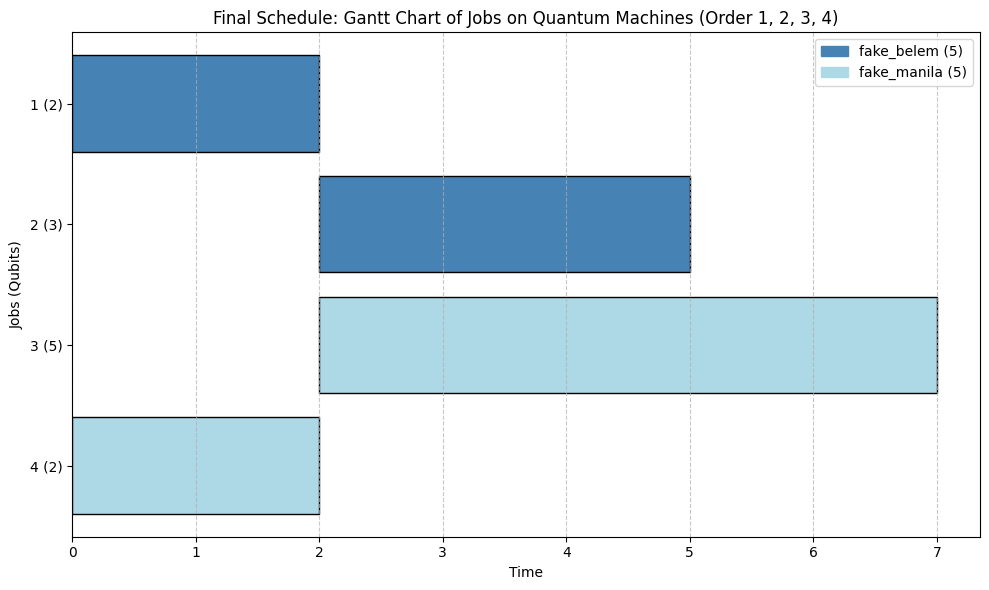

In [13]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def visualize_gantt_chart_from_json(json_file: str):
    """
    Reads job data from a JSON file and visualizes the Gantt chart.
    
    Args:
        json_file (str): Path to the JSON file containing job data.
    """
    # Load data from the JSON file
    try:
        with open(json_file, 'r', encoding='utf-8') as file:
            jobs = json.load(file)
    except FileNotFoundError:
        print(f"Error: File '{json_file}' not found.")
        return
    except json.JSONDecodeError:
        print(f"Error: File '{json_file}' is not a valid JSON.")
        return

    # Normalize time to seconds (convert to a smaller scale for visualization)

    # Sort jobs by job ID (to enforce vertical order 1, 2, 3, 4)
    jobs.sort(key=lambda x: int(x['job']))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Colors for each machine
    colors = {
        'fake_belem': 'steelblue',
        'fake_manila': 'lightblue'
    }

    # Creating patches for legend
    patches = [
        mpatches.Patch(color='steelblue', label='fake_belem (5)'),
        mpatches.Patch(color='lightblue', label='fake_manila (5)')
    ]

    # Add jobs to the Gantt chart
    for job in jobs:
        ax.barh(
            y=f"{job['job']} ({job['qubits']})", 
            width=job['duration'], 
            left=job['start'], 
            color=colors[job['machine']], 
            edgecolor='black'
        )

    # Reverse the y-axis
    ax.invert_yaxis()

    # Add legend
    ax.legend(handles=patches, loc='upper right')

    # Labels and title
    ax.set_xlabel("Time")
    ax.set_ylabel("Jobs (Qubits)")
    ax.set_title("Final Schedule: Gantt Chart of Jobs on Quantum Machines (Order 1, 2, 3, 4)")

    # Grid and layout adjustments
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show plot
    plt.show()


# Example usage
json_file_path = 'job_assignment_output.json'  # Replace with your JSON file path
visualize_gantt_chart_from_json(json_file_path)